In [259]:
import pandas as pd
from datetime import datetime, date
import matplotlib.pyplot as plt
import seaborn as sns

In [260]:
############### HISTORICAL WEATHER DATA FOR BOULDER, CO ###############
raw_df = pd.read_csv('weather_data_historical.csv')

# change dt_iso to datetime
# original format: YYYY-MM-DD 00:00:00 +0000 UTC
raw_df['dt_iso'] = raw_df['dt_iso'].str[:-10]
raw_df['dt_iso'] = pd.to_datetime(raw_df['dt_iso'], format='%Y-%m-%d %H:%M:%S')

# just to make sure
raw_df.sort_values('dt_iso', inplace=True)

# set datetime index for later down sample
raw_df.set_index('dt_iso', inplace=True)

#######################################################################
'''
UNITS:
temp_min / temp_max - the min and max temps at the moment
timezone - shift in seconds from UTC
temp - C
visibility - m
dew_point - kelvin
feels like - C
pressure - hPA
humidity - %
wind_speed - m/s
wind_deg - deg (meteorological)
wind_gust - m/s
rain_1h - mm
snow_1h - mm
clouds_all - %
weather_id - weather condition id
weather_main - group of weather parameters (rain, snow, extreme)
''';

In [261]:
# drop columns with all null values
raw_df.drop(columns=['sea_level', 'grnd_level', 'snow_3h', 'rain_3h' ], inplace=True)

# drop unneeded columns
raw_df.drop(
    columns=[
        'dt', 
        'timezone', 
        'city_name', 
        'lat', 
        'lon', 
        'clouds_all', 
        'weather_id', 
        'weather_main', 
        'weather_description',
        'weather_icon'
    ], inplace=True
)

In [262]:
# handle null values

# if wind_gust = NaN, fill with value from wind_speed
raw_df['wind_gust'] = raw_df['wind_gust'].fillna(raw_df['wind_speed'])

# fill NaN for snow and rainfall with 0
raw_df[['rain_1h', 'snow_1h']] = raw_df[['rain_1h', 'snow_1h']].fillna(float(0))

In [263]:
# no null values
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 378309 entries, 1979-01-01 00:00:00 to 2021-12-31 23:00:00
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   temp        378309 non-null  float64
 1   visibility  101498 non-null  float64
 2   dew_point   378309 non-null  float64
 3   feels_like  378309 non-null  float64
 4   temp_min    378309 non-null  float64
 5   temp_max    378309 non-null  float64
 6   pressure    378309 non-null  int64  
 7   humidity    378309 non-null  int64  
 8   wind_speed  378309 non-null  float64
 9   wind_deg    378309 non-null  int64  
 10  wind_gust   378309 non-null  float64
 11  rain_1h     378309 non-null  float64
 12  snow_1h     378309 non-null  float64
dtypes: float64(10), int64(3)
memory usage: 40.4 MB


In [264]:
# select columns we will use for our analysis
cols = [
    'temp',
    'wind_speed',
    'wind_gust',
    'rain_1h',
    'snow_1h',
]

# select aggregations to down sample features
aggs = {
    'temp': 'mean',
    'wind_speed': 'mean',
    'wind_gust': 'max',
    'rain_1h': 'sum',
    'snow_1h': 'sum'
}


# select column names for after aggregations
names = {
    'temp': 'mean_temp',
    'wind_speed': 'mean_wind_speed',
    'wind_gust': 'max_wind_speed',
    'rain_1h': 'rain_total',
    'snow_1h': 'snow_total'
}

In [265]:
# create copy of raw_df and down sample hourly -> daily
df = raw_df[cols].resample('D').agg(aggs).rename(columns=names)

In [266]:
# add additional columns for max and min temp of each day
df['max_temp'] = raw_df['temp'].resample('D').max()
df['min_temp'] = raw_df['temp'].resample('D').min()

In [267]:
df.head()

,mean_temp,mean_wind_speed,max_wind_speed,rain_total,snow_total,max_temp,min_temp
dt_iso,,,,,,,
1979-01-01,-20.025000,1.778750,4.97,0.0,0.73,-16.33,-23.03
1979-01-02,-15.195833,4.087500,6.11,0.0,0.00,-5.64,-22.49
1979-01-03,-10.642083,2.618333,3.77,0.0,0.00,-3.28,-16.55
1979-01-04,-11.774167,1.631667,3.47,0.0,0.00,-6.76,-16.72
1979-01-05,-15.053333,1.067500,2.09,0.0,0.11,-9.85,-19.02


In [268]:
# create additional date columns
df['year'] = df.index.year
df['month_name'] = df.index.month_name()
df['month'] = df.index.month
df['day_of_month'] = df.index.day
df['day_of_year'] = df.index.strftime('%j')

In [269]:
# reorder columns for clarity
cols_reorder = ['year', 'month_name', 'month', 'day_of_month', 'day_of_year', 'max_temp', 'min_temp'] + list(names.values())

df = df[cols_reorder]

In [274]:
df.head()

,year,month_name,month,day_of_month,day_of_year,max_temp,min_temp,mean_temp,mean_wind_speed,max_wind_speed,rain_total,snow_total
dt_iso,,,,,,,,,,,,
1979-01-01,1979,January,1,1,001,-16.33,-23.03,-20.025000,1.778750,4.97,0.0,0.73
1979-01-02,1979,January,1,2,002,-5.64,-22.49,-15.195833,4.087500,6.11,0.0,0.00
1979-01-03,1979,January,1,3,003,-3.28,-16.55,-10.642083,2.618333,3.77,0.0,0.00
1979-01-04,1979,January,1,4,004,-6.76,-16.72,-11.774167,1.631667,3.47,0.0,0.00
1979-01-05,1979,January,1,5,005,-9.85,-19.02,-15.053333,1.067500,2.09,0.0,0.11


In [271]:
df.describe()

,year,month,day_of_month,max_temp,min_temp,mean_temp,mean_wind_speed,max_wind_speed,rain_total,snow_total
count,15706.000000,15706.000000,15706.000000,15706.000000,15706.000000,15706.000000,15706.000000,15706.000000,15706.000000,15706.000000
mean,2000.000000,6.522858,15.729848,14.928995,1.019455,7.155273,2.171942,4.995332,1.722560,0.661801
std,12.410238,3.448833,8.800461,10.137916,8.806356,9.555276,0.878631,3.444846,4.378536,2.915628
min,1979.000000,1.000000,1.000000,-23.720000,-33.680000,-26.452917,0.150000,1.340000,0.000000,0.000000
25%,1989.000000,4.000000,8.000000,7.130000,-5.300000,-0.277708,1.620521,3.200000,0.000000,0.000000
50%,2000.000000,7.000000,16.000000,15.440000,1.145000,7.094167,2.049583,3.840000,0.000000,0.000000
75%,2011.000000,10.000000,23.000000,23.410000,8.420000,15.510640,2.593229,4.920000,1.510000,0.000000
max,2021.000000,12.000000,31.000000,39.110000,24.170000,30.244000,10.608333,32.900000,98.260000,132.520000


In [272]:
corr_map = df.corr()
corr_map.style.background_gradient(cmap='coolwarm').set_precision(2)

,year,month,day_of_month,max_temp,min_temp,mean_temp,mean_wind_speed,max_wind_speed,rain_total,snow_total
year,1.00,-0.00,-0.00,0.15,0.16,0.15,-0.16,0.44,0.07,-0.02
month,-0.00,1.00,0.01,0.17,0.19,0.18,-0.09,-0.06,0.01,-0.04
day_of_month,-0.00,0.01,1.00,0.00,0.01,0.01,0.00,0.01,-0.00,0.01
max_temp,0.15,0.17,0.00,1.00,0.92,0.97,-0.12,0.10,0.14,-0.28
min_temp,0.16,0.19,0.01,0.92,1.00,0.98,-0.14,0.11,0.28,-0.20
mean_temp,0.15,0.18,0.01,0.97,0.98,1.00,-0.14,0.10,0.20,-0.25
mean_wind_speed,-0.16,-0.09,0.00,-0.12,-0.14,-0.14,1.00,0.46,-0.14,0.01
max_wind_speed,0.44,-0.06,0.01,0.10,0.11,0.10,0.46,1.00,0.02,0.00
rain_total,0.07,0.01,-0.00,0.14,0.28,0.20,-0.14,0.02,1.00,0.00
snow_total,-0.02,-0.04,0.01,-0.28,-0.20,-0.25,0.01,0.00,0.00,1.00


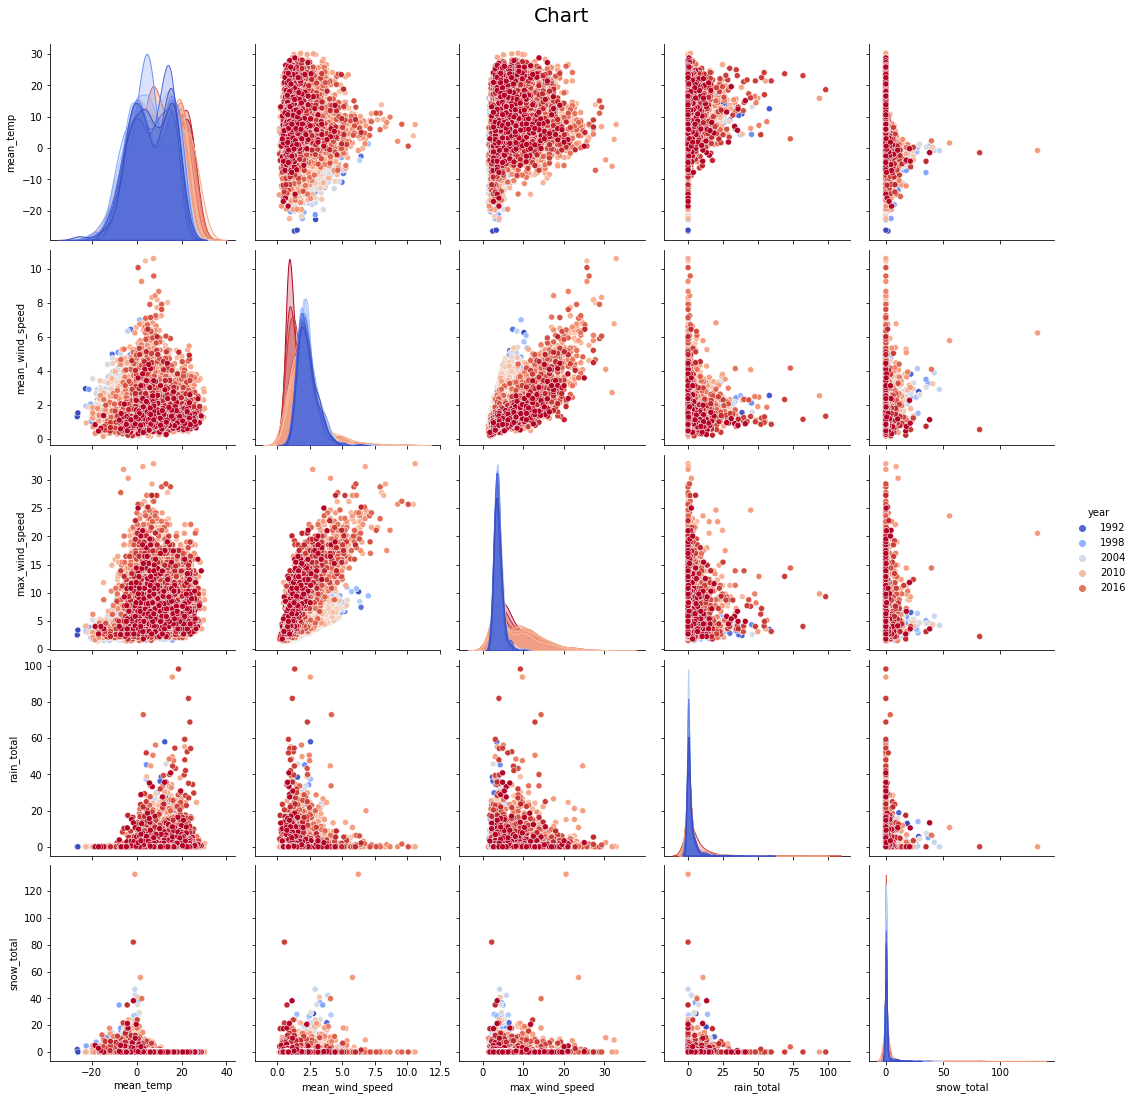

In [273]:
sns.pairplot(
    df[df['year'] >=1990],
    height=3,
    vars=[
        'mean_temp',
        'mean_wind_speed',
        'max_wind_speed',
        'rain_total',
        'snow_total',
    ],
    hue='year',
    palette='coolwarm'
)
plt.suptitle('Chart', fontsize=20, y=1.02)
plt.show()
